COGS 118B Final Project - Credit Risk Prediction with Hybrid Modeling

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import plot_tree

import xgboost as xgb

In [206]:
# import dataset
app_df = pd.read_csv('datasets/application_record.csv')
credit_df = pd.read_csv('datasets/credit_record.csv')

# Drop FLAG_MOBIL column because it is a constant
print(app_df['FLAG_MOBIL'].value_counts())
app_df = app_df.drop("FLAG_MOBIL", axis=1)

FLAG_MOBIL
1    438557
Name: count, dtype: int64


In [207]:
# Data cleaning for classification
credit_df['STATUS'] = credit_df['STATUS'].replace('X', '-2')
credit_df['STATUS'] = credit_df['STATUS'].replace('C', '-1')
credit_df['STATUS'] = credit_df['STATUS'].astype(int)
credit_df['MONTHS_BALANCE'] = credit_df['MONTHS_BALANCE'].astype(int)

In [208]:
# generate a credit level label for each client based on credit history record
def two_classes(client):
    if client['STATUS'].max() <= 0:
        recent = client[client['MONTHS_BALANCE'] >= -6]
        if recent['STATUS'].max() <= 0:
            return 'Prime'
    return 'Subprime'

label_df_2 = credit_df.groupby('ID').apply(two_classes).to_frame()
label_df_2 = label_df_2.rename(columns={0: 'CLASS'})


def four_classes(client):
    recent = client[client['MONTHS_BALANCE'] >= -6]
    worst_status = client['STATUS'].max()
    worst_recent_status = recent['STATUS'].max()

    if worst_status < 0:
        if worst_recent_status < 0:
            return 'Super-prime'
    if worst_status <= 0:
        if worst_recent_status <= 0:
            return 'Prime'
    if worst_status <= 3:
        if worst_recent_status <= 1:
            return 'Near-prime'
    '''
    if worst_status <= 5:
        if worst_recent_status <= 3:
            return 'Subprime'
    '''
    return 'Subprime'
    
label_df_4 = credit_df.groupby('ID').apply(four_classes).to_frame()
label_df_4 = label_df_4.rename(columns={0: 'CLASS'})

/var/folders/sb/cdw7gr054nvc469rwn15_4q00000gn/T/ipykernel_73989/1480022293.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_df_2 = credit_df.groupby('ID').apply(two_classes).to_frame()
/var/folders/sb/cdw7gr054nvc469rwn15_4q00000gn/T/ipykernel_73989/1480022293.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_df_4 = credit_df.groupby('ID').apply(four_classes).to_frame()


In [209]:
# concat label to the application dataframe and change index to ID
label_app_df_2 = pd.merge(app_df, label_df_2, left_on='ID', right_index=True, how='inner')
label_app_df_2 = label_app_df_2.set_index('ID')

label_app_df_4 = pd.merge(app_df, label_df_4, left_on='ID', right_index=True, how='inner')
label_app_df_4 = label_app_df_4.set_index('ID')
label_app_df_4.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLASS
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,Near-prime
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,Near-prime
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,Prime
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,Prime
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,Subprime


In [210]:
label_app_df_4['CLASS'].value_counts()

CLASS
Prime          20311
Subprime        9381
Super-prime     3706
Near-prime      3059
Name: count, dtype: int64

In [211]:
# Encode columns with string labels
df = label_app_df_2
str_columns = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", 
            "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"]
for col in str_columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])


# Prepare trainning and testing data
X = df.drop("CLASS", axis=1)
y = df["CLASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,2.0
5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0
5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0


In [212]:
# Feature selection function (choose top n features)
def feature_selection(X_train, X_test, n):
    selector = SelectKBest(score_func=f_classif, k=n)
    selector.fit(X_train, y_train)

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    selected_mask = selector.get_support()
    features = X_train.columns[selected_mask]

    X_train_selected = pd.DataFrame(X_train_selected, columns=features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=features, index=X_test.index)  

    return X_train_selected, X_test_selected, features

# Show the original features
original_features = X_train.columns
print(original_features)

# Choose the top 10 features
X_train_selected, X_test_selected, selected_features = feature_selection(X_train, X_test, 10)
print(selected_features)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')
Index(['FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS'],
      dtype='object')


1. Random Forest

In [213]:
# Run Random Forest
def run_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)

    return accuracy, report

rf_accuracy, rf_report = run_random_forest(X_train, X_test, y_train, y_test)

Accuracy: 0.6557871640153593
Classification Report:
              precision    recall  f1-score   support

       Prime       0.71      0.80      0.76      4820
    Subprime       0.49      0.37      0.42      2472

    accuracy                           0.66      7292
   macro avg       0.60      0.59      0.59      7292
weighted avg       0.64      0.66      0.64      7292



2. XGBoost Classifier

Accuracy: 0.6644267690619857
Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      4820
           1       0.68      0.02      0.04      2472

    accuracy                           0.66      7292
   macro avg       0.67      0.51      0.42      7292
weighted avg       0.67      0.66      0.54      7292



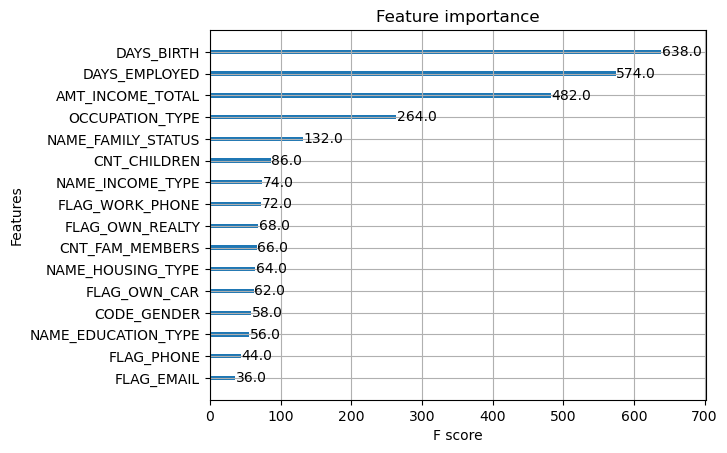

In [214]:
# Change the label to numerical for XGBoost

y_train_xgb = y_train.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 2, 'Near-prime':3})
y_test_xgb = y_test.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 2, 'Near-prime':3})


# Run XGBoost
def run_xgboost(X_train, X_test, y_train, y_test):
    xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=2, max_depth=4, learning_rate=0.1, n_estimators=100, random_state=2)
    '''
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(set(y_train)), 
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100,
        random_state=2
    )
    '''
    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)
    
   
    xgb.plot_importance(xgb_classifier)
    # plt.gca().set_yticklabels(features)
    '''
    importance_plt = xgb.plot_importance(xgb_classifier)
    plt.gca().set_yticklabels(features[:len(importance_plt.get_yticklabels())])  
    '''
    plt.show()
    
    return accuracy, report

xgb_accuracy, xrb_report = run_xgboost(X_train, X_test, y_train_xgb, y_test_xgb)

k-mean clustering

In [215]:
def run_kmean(X_train, n_clusters):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    
    # Add cluster labels to the dataset
    X_train_with_clusters = X_train.copy()
    X_train_with_clusters['cluster'] = cluster_labels
    return X_train_with_clusters, kmeans


In [217]:
def run_each_cluster(X_train_with_clusters, X_test, y_train, y_test, kmeans):
    
    rf_reports = {}
    xgb_reports = {}
    rf_overall_accuracy = 0
    xgb_overall_accuracy = 0
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)  
    test_clusters = kmeans.predict(X_test_scaled) 
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['cluster'] = test_clusters

    for cluster in sorted(X_train_with_clusters['cluster'].unique()):
        print(f"\nCluster {cluster}:")

        X_train_cluster = X_train_with_clusters[X_train_with_clusters['cluster'] == cluster].drop('cluster', axis=1)
        y_train_cluster = y_train.loc[X_train_with_clusters['cluster'] == cluster]

        X_test_cluster = X_test_with_clusters[X_test_with_clusters['cluster'] == cluster].drop('cluster', axis=1)
        y_test_cluster = y_test.loc[X_test_with_clusters['cluster'] == cluster]

        '''
        # run feature selection
        print("run feature selection:")
        selector = SelectKBest(score_func=f_classif, k=n_features)
        selector.fit(X_train_cluster, y_train_cluster)

        X_train_selected = selector.transform(X_train_cluster)
        X_test_selected = selector.transform(X_test_cluster)
        selected_features = X_train_cluster.columns[selector.get_support()]
        print(f"Selected Features for Cluster {cluster}: {selected_features.tolist()}")
        '''

        # run RF:
        print("\nRun Random Forest:")
        rf_accuracy, rf_report = run_random_forest(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster)
        rf_reports[cluster] = rf_report
        rf_overall_accuracy += rf_accuracy * X_test_cluster.shape[0]

        # run XGBoost:
        y_train_cluster_xgb = y_train_cluster.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 2, 'Near-prime': 3})
        y_test_cluster_xgb = y_test_cluster.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 2, 'Near-prime': 3})
        print("\nRun XGBoost:")
        xgb_accuracy, xgb_report = run_xgboost(X_train_cluster, X_test_cluster, y_train_cluster_xgb, y_test_cluster_xgb)
        xgb_reports[cluster] = xgb_report
        xgb_overall_accuracy += xgb_accuracy * X_test_cluster.shape[0]

    # print overall accuracy
    print("Overall Random Forest Accuracy:", rf_overall_accuracy/X_test_with_clusters.shape[0])
    print("Overall XGBoost Accuracy:", xgb_overall_accuracy/X_test_with_clusters.shape[0])

    return rf_reports, xgb_reports



Cluster 0:

Run Random Forest:
Accuracy: 0.6629955947136564
Classification Report:
              precision    recall  f1-score   support

       Prime       0.70      0.84      0.76       294
    Subprime       0.53      0.34      0.42       160

    accuracy                           0.66       454
   macro avg       0.62      0.59      0.59       454
weighted avg       0.64      0.66      0.64       454


Run XGBoost:
Accuracy: 0.6563876651982379
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       294
           1       0.54      0.16      0.25       160

    accuracy                           0.66       454
   macro avg       0.61      0.54      0.51       454
weighted avg       0.62      0.66      0.59       454



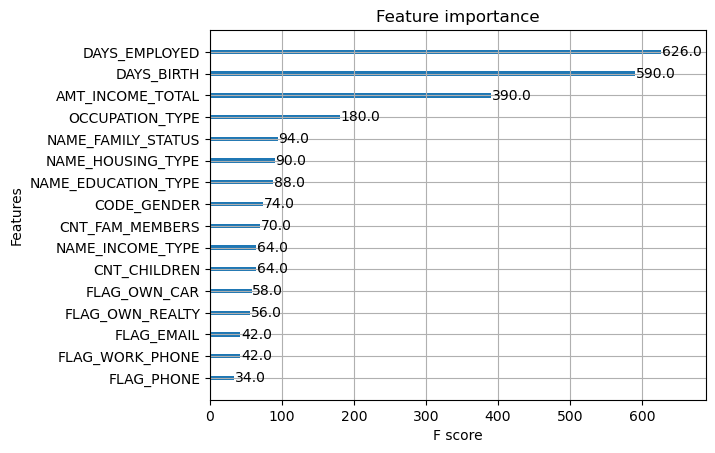


Cluster 1:

Run Random Forest:
Accuracy: 0.6238125395820139
Classification Report:
              precision    recall  f1-score   support

       Prime       0.70      0.76      0.73      1041
    Subprime       0.44      0.36      0.39       538

    accuracy                           0.62      1579
   macro avg       0.57      0.56      0.56      1579
weighted avg       0.61      0.62      0.61      1579


Run XGBoost:
Accuracy: 0.6542115262824573
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.95      0.78      1041
           1       0.46      0.08      0.13       538

    accuracy                           0.65      1579
   macro avg       0.56      0.52      0.46      1579
weighted avg       0.59      0.65      0.56      1579



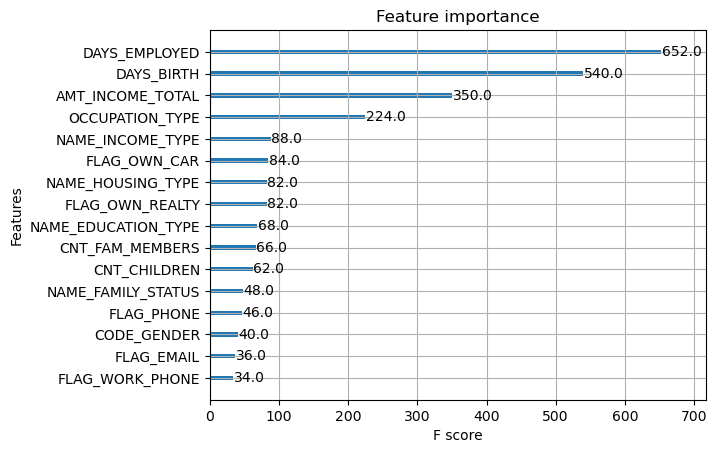


Cluster 2:

Run Random Forest:
Accuracy: 0.6580118694362018
Classification Report:
              precision    recall  f1-score   support

       Prime       0.71      0.81      0.75      1749
    Subprime       0.52      0.38      0.44       947

    accuracy                           0.66      2696
   macro avg       0.61      0.60      0.60      2696
weighted avg       0.64      0.66      0.64      2696


Run XGBoost:
Accuracy: 0.6554154302670623
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.98      0.79      1749
           1       0.61      0.05      0.10       947

    accuracy                           0.66      2696
   macro avg       0.63      0.52      0.44      2696
weighted avg       0.64      0.66      0.54      2696



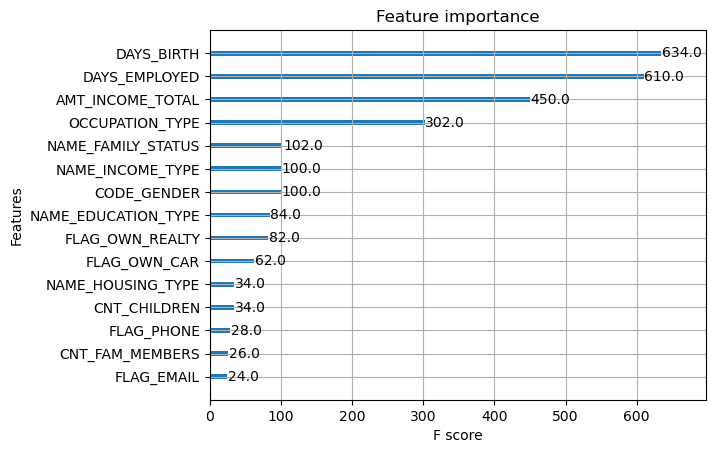


Cluster 3:

Run Random Forest:
Accuracy: 0.6757201646090535
Classification Report:
              precision    recall  f1-score   support

       Prime       0.75      0.80      0.77       836
    Subprime       0.48      0.39      0.43       379

    accuracy                           0.68      1215
   macro avg       0.61      0.60      0.60      1215
weighted avg       0.66      0.68      0.67      1215


Run XGBoost:
Accuracy: 0.6946502057613169
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       836
           1       0.62      0.06      0.10       379

    accuracy                           0.69      1215
   macro avg       0.66      0.52      0.46      1215
weighted avg       0.67      0.69      0.59      1215



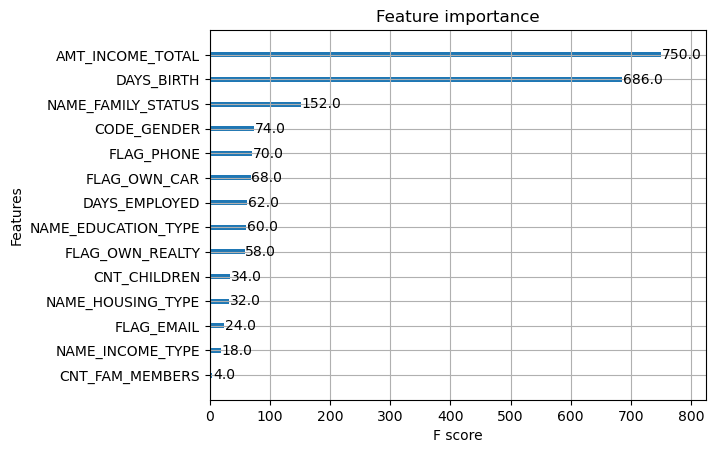


Cluster 4:

Run Random Forest:
Accuracy: 0.6728486646884273
Classification Report:
              precision    recall  f1-score   support

       Prime       0.72      0.83      0.77       900
    Subprime       0.51      0.35      0.42       448

    accuracy                           0.67      1348
   macro avg       0.62      0.59      0.59      1348
weighted avg       0.65      0.67      0.65      1348


Run XGBoost:
Accuracy: 0.6669139465875371
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       900
           1       0.49      0.09      0.16       448

    accuracy                           0.67      1348
   macro avg       0.59      0.52      0.48      1348
weighted avg       0.62      0.67      0.58      1348



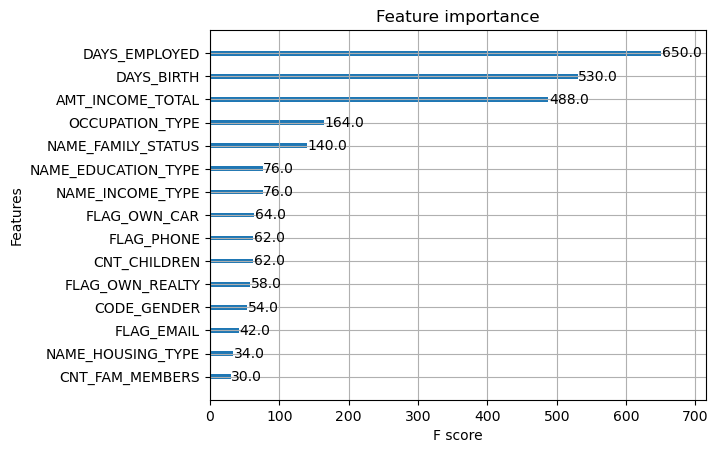

Overall Random Forest Accuracy: 0.6566099835436094
Overall XGBoost Accuracy: 0.663878222709819


In [219]:
# run k-mean
X_train_with_clusters, kmeans = run_kmean(X_train.copy(), n_clusters=5)
rf_reports, xgb_reports = run_each_cluster(X_train_with_clusters, X_test.copy(), y_train, y_test, kmeans)